Let's start a metric that tries to compute the volume of star forming regions one could observe

In [1]:
from lsst.sims.maf.metrics.baseMetric import BaseMetric
import lsst.sims.maf.utils as mafUtils
import lsst.sims.utils as utils
from scipy import interpolate

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

from lsst.sims.utils import _galacticFromEquatorial
from lsst.sims.photUtils import Dust_values

In [2]:
class StarVolumeMetric(BaseMetric):
    """Calculate the distance to which one could reach color uncertainties


    Parameters
    ----------
    metricName : str, opt
        Default 'parallax'.
    m5Col : str, opt
        The default column name for m5 information in the input data. Default fiveSigmaDepth.
    filterCol : str, opt
        The column name for the filter information. Default filter.
    mags : dict
        The absolute magnitude of the object in question. Keys of filter name, values in mags.
        Default is for a 0.3 solar mass star at age = 100 Myr.
    snrs : dict
        The SNR to demand for each filter.
    galb_limit : float (25.)
        The galactic latitude above which to return zero (degrees). 
    badval : float, opt
        The value to return when the metric value cannot be calculated. Default 0.
    """
    def __init__(self, metricName='star_vol', m5Col='fiveSigmaDepth',
                 filterCol='filter',
                 badval=0, mags={'g': 10.8 , 'r': 11.9, 'i': 9.6}, galb_limit=25.,
                 snrs={'g': 5., 'r': 5., 'i': 5.},
                 **kwargs):
        Cols = [m5Col, filterCol]
        maps = ['DustMap']
        
        units = 'pc'
        super(StarVolumeMetric, self).__init__(Cols, metricName=metricName, units=units,
                                             badval=badval, maps=maps, *kwargs)
        # set return type
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.galb_limit = np.radians(galb_limit)
        
        self.mags = mags
        self.filters = list(self.mags.keys())
        self.snrs = snrs
        # Load up the dust properties
        dust_properties = Dust_values()
        self.Ax1 = dust_properties.Ax1
        
    def run(self, dataSlice, slicePoint=None):
        
        # if we are outside the galb_limit, return nothing
        # Note we could make this a more comlicated function that returns an expected density of 
        # star forming regions
        if np.abs(slicePoint['galb']) > self.galb_limit:
            return self.badval
        
        # Coadd depths for each filter
        depths = {}
        for filtername in self.filters:
            in_filt = np.where(dataSlice[self.filterCol] == filtername)[0]
            depths[filtername] = 1.25 * np.log10(np.sum(10.**(.8*dataSlice[self.m5Col])))
           
        # solve for the distances in each filter where we hit the required SNR
        distances = []
        for filtername in self.filters:
            # Apparent magnitude at the SNR requirement
            m_app = -2.5*np.log10(self.snrs[filtername]/5.) + depths[filtername]
            A_x = self.Ax1[filtername] * slicePoint['ebv']
            # Assuming all the dust along the line of sight matters. 
            m_app = m_app - A_x
            
            d = 10.*(100**((m_app - self.mags[filtername])/5.))**0.5
            distances.append(d)
            
        result = np.min(distances)
        
        return result

class VolumeSumMetric(BaseMetric):
    """Compute the total volume assuming a metric has values of distance
    """
    def __init__(self, col=None, metricName='VolumeSum', nside=None, **kwargs):
        super(VolumeSumMetric, self).__init__(col=col, metricName=metricName, **kwargs)
        self.pix_area = hp.nside2pixarea(nside)
        
    def run(self, dataSlice, slicePoint=None):
        # volume of sphere, times ratio of pixel area divided by area of sphere
        vols = 1./3. * dataSlice[self.colname]**3 * self.pix_area
        return np.sum(vols)



In [3]:
dbFile = 'baseline_nexp2_v1.7_10yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [4]:
nside = 64
bundleList = []
sql = ''
# Let's plug in the magnitudes for one type
metric = StarVolumeMetric()
slicer = slicers.HealpixSlicer(nside=nside)
# By default, the slicer uses RA and Dec. Let's add in galactic coords so it knows 
gall, galb = _galacticFromEquatorial(slicer.slicePoints['ra'],slicer.slicePoints['dec'])
slicer.slicePoints['gall'] = gall
slicer.slicePoints['galb'] = galb

summaryStats = [VolumeSumMetric(nside=nside)]
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                             runName=runName))


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'filter'].
Found 2045493 visits
Running:  ['baseline_nexp2_v1_7_10yrs_star_vol_HEAL']


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:110: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/maps/dustMap.py:24: UserWarning: Slicer value of nside (64) different from map value (128), using slicer value
  warnings.warn('Slicer value of nside (%i) different from map value (%i), using slicer value'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 6248.99  dipole: lon: 150.262, lat: -41.0433, amp: 2767.07
  warnings.warn(


Plotting complete.


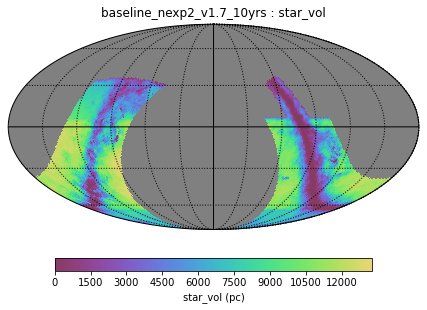

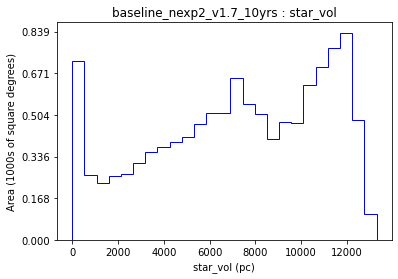

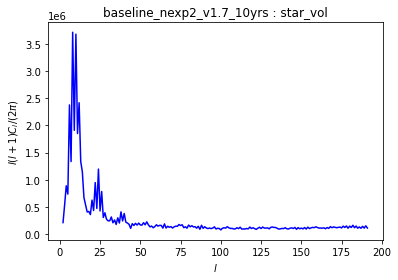

In [5]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)


In [6]:
for bl in bundleList:
    print(bl.metric.name, bl.summaryValues)

star_vol {'VolumeSum': 783572146682.2728}


Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'filter'].
Found 2044789 visits
Running:  ['baseline_nexp2_v1_7_10yrs_star_vol_HEAL']


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:110: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/maps/dustMap.py:24: UserWarning: Slicer value of nside (64) different from map value (128), using slicer value
  warnings.warn('Slicer value of nside (%i) different from map value (%i), using slicer value'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 6429.9  dipole: lon: 150.705, lat: -43.5677, amp: 2158.4
  warnings.warn(


Plotting complete.


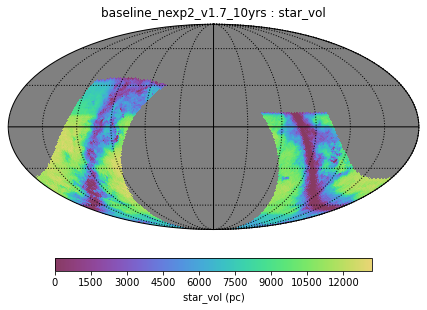

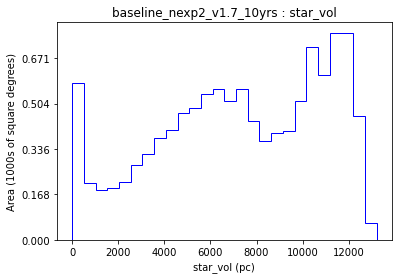

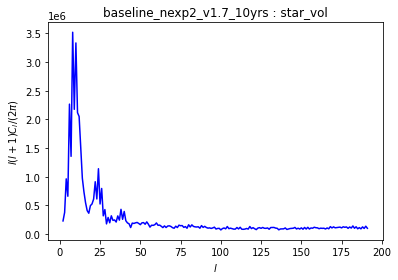

In [7]:
# Now to run on a different footprint
dbFile = 'footprint_6_v1.710yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)


In [8]:
for bl in bundleList:
    print(bl.metric.name, bl.summaryValues)

star_vol {'VolumeSum': 753912711588.9924}


## Things that need to be modified to make this a useful metric

* Put in realistic default absolute magnitudes
* Check that the SNR limit is realistic
* I think we need a function (could be fairly rough) that returns the density of star forming regions given a galactic latitude and longitude. l,b --> expected star forming regions/sq degree
* Do we need a more complicated dust model? 